In [466]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
from scipy.misc import logsumexp
import imp
imp.reload(simple_vae)
from simple_vae import NonLocalVAE, VAE

from scipy import spatial


# TSNE

In [383]:
from sklearn.manifold import TSNE
qz_reduced = TSNE(n_components=2, random_state=0).fit_transform(latent[:1000])

0
1
2
3
4


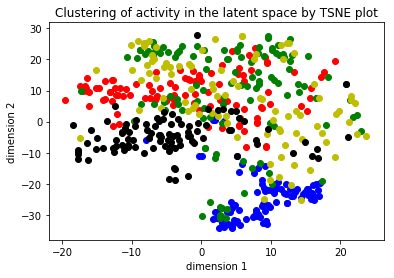

In [384]:
c = ['r', 'blue', 'g', 'y', 'black']
label = list(np.arange(10))
for i in range(5):
    print(i)
    
    plt.scatter(qz_reduced[np.where(test_target[:1000]==i),0], qz_reduced[np.where(test_target[:1000]==i), 1], c=c[i], label=label[i])
plt.title('Clustering of activity in the latent space by TSNE plot')
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')    

In [290]:
# np.asarray([0.7272727489471436,
# 0.575757622718811,
# 0.7878788113594055,
# 0.605757622718811,
# 0.7575757503509521]).mean()

In [432]:
def get_latent(model, data, latent_dim=50):
    model.eval()
    for i, (data, label) in enumerate(test_loader):
        recon_batch, mu, logvar = model(data.cuda())
    
    latent = model.z * model.theta
    latent = latent.view(-1, latent_dim).cpu().detach().numpy()
    return latent, label


def get_pairwise_cosine(latent, label):
    mean_vec = np.zeros([10, latent.shape[1]])
    for i in range(10):
        mean_vec[i, :] = latent[np.where(label == i)].mean(axis=0)
    
    cosine_matrix = np.zeros([10, 10])
    for i in range(10):
        for j in range(i, 10):
            cosine_matrix[i, j] = spatial.distance.cosine(mean_vec[i], mean_vec[j]) 
            cosine_matrix[j, i] = cosine_matrix[i, j]
    return 1 - cosine_matrix, mean_vec

In [464]:
def get_cosine(prior, tau, p, latent_dim):# 'imom' 'Gaussian'
    epochs = 20
    result_dir = '/extra/yadongl10/git_project/nlpresult/vae_exp/0217'
    model_dir = result_dir + '/nlpvae_{}_latent{}_epoch{}_tau{}_p{}.pt'.format(prior, latent_dim, epochs, tau, p)
    print(model_dir)
    checkpoint = torch.load(model_dir)
    if prior == 'vanilla':
        model = VAE(latent_dim=latent_dim).cuda()
    else:
        model = NonLocalVAE(latent_dim=latent_dim, prior=prior, tau=tau, p=p).cuda()
    model.load_state_dict(checkpoint)

    # load data
    test_loader = torch.utils.data.DataLoader(
            datasets.MNIST('/extra/yadongl10/data', train=False, transform=transforms.ToTensor()),
            batch_size=100, shuffle=True)
    test_data, test_target = test_loader.dataset.data.float().cuda(), test_loader.dataset.targets.numpy()
    print(test_data.shape)
    
    # get latent
    if prior == 'vanilla':
        model = VAE(latent_dim=latent_dim).cuda()
        recon_batch, mu, logvar = model(test_data)
        latent = mu + 0.5 * torch.exp(logvar) * torch.rand(test_data.shape[0], logvar.shape[1]).cuda()
        latent = latent.view(-1, latent_dim).cpu().detach().numpy()
    else:
        latent, test_target = get_latent(model, test_data, latent_dim=latent_dim)

    # get similarity
    cosine_matrix, mean_vec = get_pairwise_cosine(latent, test_target)
    return cosine_matrix, mean_vec

In [436]:
cosine_gaussian, mean_vec_g = get_cosine(prior='Gaussian', tau=1, p=0.5, latent_dim=50)
cosine_vanilla, mean_vec_v = get_cosine(prior='vanilla', tau=1, p=1, latent_dim=50)
cosine_imom, mean_vec_i = get_cosine(prior='imom', tau=5, p=0.2, latent_dim=50)

/extra/yadongl10/git_project/nlpresult/vae_exp/0217/nlpvae_Gaussian_latent50_epoch20_tau1_p0.5.pt
torch.Size([10000, 28, 28])
/extra/yadongl10/git_project/nlpresult/vae_exp/0217/nlpvae_vanilla_latent50_epoch20_tau1_p1.pt
torch.Size([10000, 28, 28])
/extra/yadongl10/git_project/nlpresult/vae_exp/0217/nlpvae_imom_latent50_epoch20_tau5_p0.2.pt
torch.Size([10000, 28, 28])


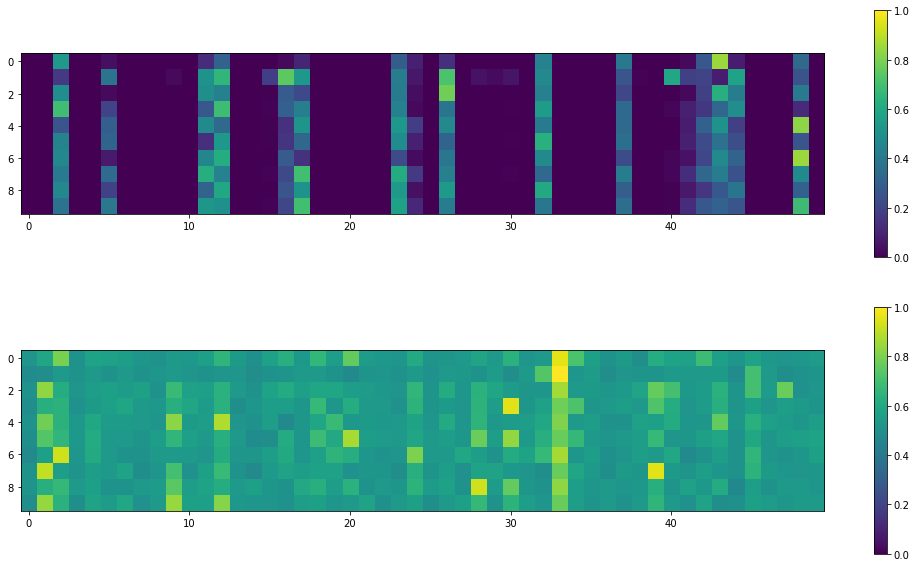

In [423]:
fig, axe = plt.subplots(2,1,figsize=(18,10))
for i, m in enumerate([mean_vec_i, mean_vec_g]):
    im1 = axe[i].imshow(m, vmin=0., vmax=1)
    cbar = fig.colorbar(im1, ax=axe[i],orientation='vertical')


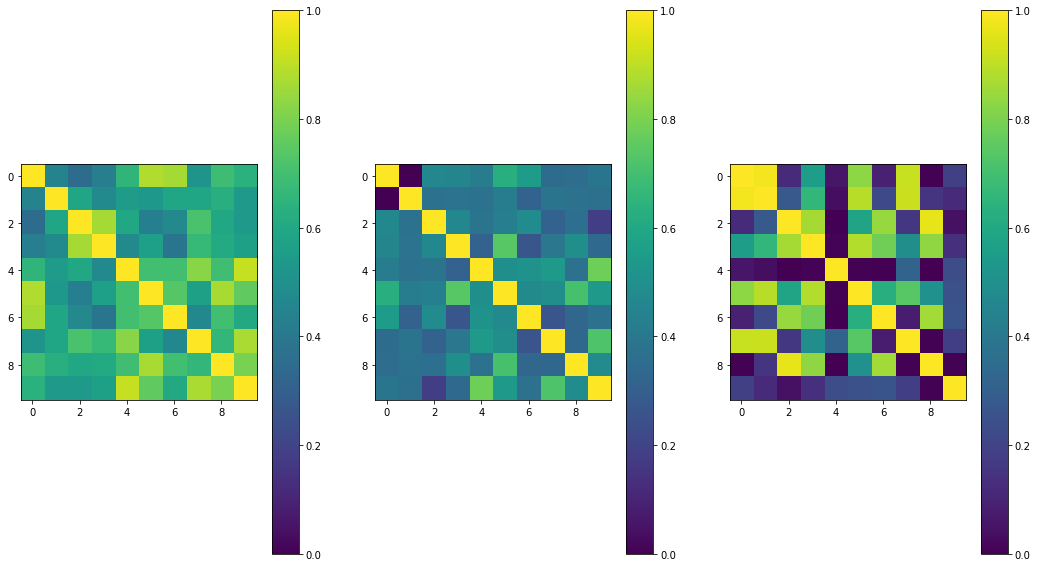

In [469]:
fig, axe = plt.subplots(1,3,figsize=(18,10))
for i, m in enumerate([cosine_mom, cosine_gaussian, cosine_vanilla]):
    im1 = axe[i].imshow(m, vmin=0., vmax=1)
    cbar = fig.colorbar(im1, ax=axe[i],orientation='vertical')


In [397]:
# result_dir = '/extra/yadongl10/git_project/nlpresult/vae_exp/0217'

# # load model 
# p = 0.2
# prior = 'imom'  # 'imom' 'Gaussian'
# tau = 5
# latent_dim = 100
# epochs = 20
# model_dir = result_dir + '/nlpvae_{}_latent{}_epoch{}_tau{}_p{}.pt'.format(prior, latent_dim, epochs, tau, p)
# print(model_dir)
# checkpoint = torch.load(model_dir)

# model = NonLocalVAE(latent_dim=latent_dim, prior=prior, tau=tau, p=p).cuda()
# model.load_state_dict(checkpoint)

# # load data
# test_loader = torch.utils.data.DataLoader(
#         datasets.MNIST('/extra/yadongl10/data', train=False, transform=transforms.ToTensor()),
#         batch_size=10000, shuffle=True)
# test_data, test_target = test_loader.dataset.data.float().cuda(), test_loader.dataset.targets.numpy()
# print(test_data.shape)

# # p = 1
# # prior = 'vanilla'  # 'imom' 'Gaussian'
# # tau = 1
# # latent_dim = 50 
# # epochs = 20

# # result_dir = '/extra/yadongl10/git_project/nlpresult/vae_exp/0217'
# # model_dir = result_dir + '/nlpvae_{}_latent{}_epoch{}_tau{}_p{}.pt'.format(prior, latent_dim, epochs, tau, p)
# # print(model_dir)
# # checkpoint = torch.load(model_dir)
# # if prior == 'vanilla':
# #     model = VAE(latent_dim=latent_dim).cuda()

/extra/yadongl10/git_project/nlpresult/vae_exp/0217/nlpvae_vanilla_latent50_epoch20_tau1_p1.pt


In [398]:
# model.eval()
# recon_batch, mu, logvar = model(test_data)
# logvar.mean()

tensor(-0.4324, device='cuda:0', grad_fn=<MeanBackward1>)

In [399]:
# recon_batch, mu, logvar = model(test_data)
# latent = mu + 0.5 * torch.exp(logvar) * torch.rand(test_data.shape[0], logvar.shape[1]).cuda()
# latent = latent.view(-1, latent_dim).cpu().detach().numpy()

In [426]:
# plt.imshow(get_pairwise_cosine(latent, test_target))
# plt.colorbar()

In [467]:
cosine_mom, mean_vec_m = get_cosine(prior='mom', tau=1, p=0.5, latent_dim=100)

/extra/yadongl10/git_project/nlpresult/vae_exp/0217/nlpvae_mom_latent100_epoch20_tau1_p0.5.pt
torch.Size([10000, 28, 28])


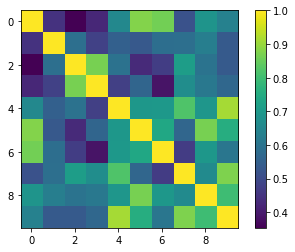

In [468]:
plt.imshow(cosine_mom)
plt.colorbar()

In [450]:
cosine_gaussian

array([[ 1.        , -0.00968559,  0.46528384,  0.45592358,  0.4234577 ,
         0.62667832,  0.55424486,  0.35390172,  0.35636533,  0.38703308],
       [-0.00968559,  1.        ,  0.37715995,  0.3792277 ,  0.37289509,
         0.42364298,  0.31306009,  0.38536492,  0.37876077,  0.36731586],
       [ 0.46528384,  0.37715995,  1.        ,  0.46723538,  0.38613962,
         0.42981587,  0.48337913,  0.3151572 ,  0.36508843,  0.18584459],
       [ 0.45592358,  0.3792277 ,  0.46723538,  1.        ,  0.31609916,
         0.73954521,  0.26888311,  0.39550125,  0.49864264,  0.34066116],
       [ 0.4234577 ,  0.37289509,  0.38613962,  0.31609916,  1.        ,
         0.49653489,  0.50809957,  0.54047857,  0.37807233,  0.77945934],
       [ 0.62667832,  0.42364298,  0.42981587,  0.73954521,  0.49653489,
         1.        ,  0.47322587,  0.49482216,  0.7106893 ,  0.54150257],
       [ 0.55424486,  0.31306009,  0.48337913,  0.26888311,  0.50809957,
         0.47322587,  1.        ,  0.26385985

(array([  1.,   0.,  91.,   2.,   1.,   1.,   1.,   0.,   1.,   2.]),
 array([-0.7580412 , -0.48882768, -0.21961415,  0.04959938,  0.31881291,
         0.58802643,  0.85723996,  1.12645349,  1.39566702,  1.66488054,
         1.93409407]),
 <a list of 10 Patch objects>)

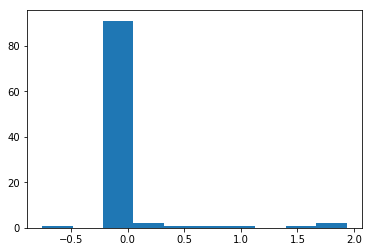

In [477]:
plt.hist(mean_vec_m[9])

In [480]:
def get_cosine(prior, tau, p, latent_dim):# 'imom' 'Gaussian'
    epochs = 10
    result_dir = '/extra/yadongl10/git_project/nlpresult/vae_exp/0219'
    model_dir = result_dir + '/nlpvae_{}_latent{}_epoch{}_tau{}_p{}.pt'.format(prior, latent_dim, epochs, tau, p)
    print(model_dir)
    checkpoint = torch.load(model_dir)
    if prior == 'vanilla':
        model = VAE(latent_dim=latent_dim).cuda()
    else:
        model = NonLocalVAE(latent_dim=latent_dim, prior=prior, tau=tau, p=p).cuda()
    model.load_state_dict(checkpoint)

    # load data
    test_loader = torch.utils.data.DataLoader(
            datasets.MNIST('/extra/yadongl10/data', train=False, transform=transforms.ToTensor()),
            batch_size=100, shuffle=True)
    test_data, test_target = test_loader.dataset.data.float().cuda(), test_loader.dataset.targets.numpy()
    print(test_data.shape)
    
    # get latent
    if prior == 'vanilla':
        model = VAE(latent_dim=latent_dim).cuda()
        recon_batch, mu, logvar = model(test_data)
        latent = mu + 0.5 * torch.exp(logvar) * torch.rand(test_data.shape[0], logvar.shape[1]).cuda()
        latent = latent.view(-1, latent_dim).cpu().detach().numpy()
    else:
        latent, test_target = get_latent(model, test_data, latent_dim=latent_dim)

    # get similarity
    cosine_matrix, mean_vec = get_pairwise_cosine(latent, test_target)
    return cosine_matrix, mean_vec
cosine_matrix, mean_vec = get_cosine('imom', tau=1, p=0.8, latent_dim=50)

/extra/yadongl10/git_project/nlpresult/vae_exp/0219/nlpvae_imom_latent50_epoch10_tau1_p0.8.pt
torch.Size([10000, 28, 28])


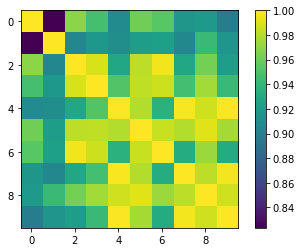

In [482]:
plt.imshow(cosine_matrix)
plt.colorbar()